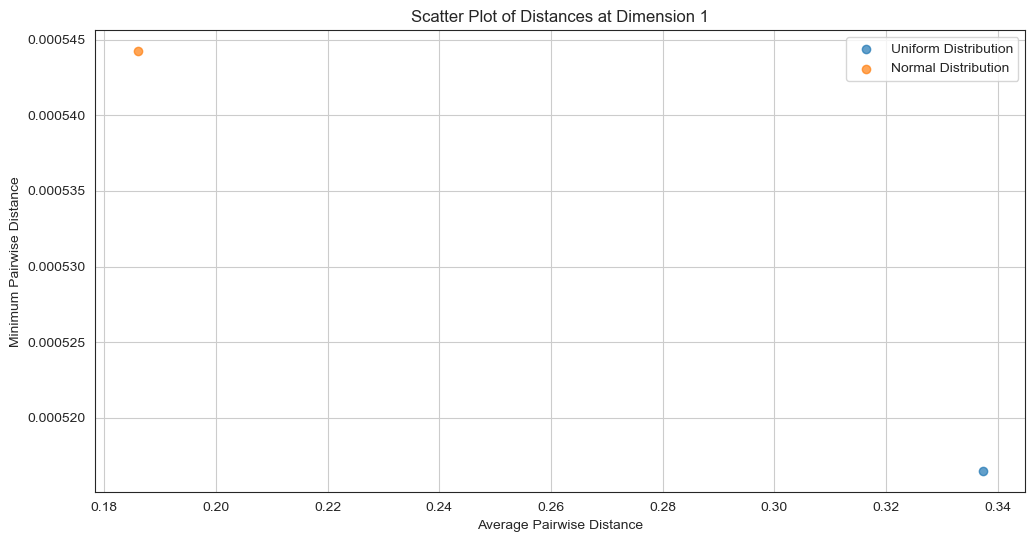

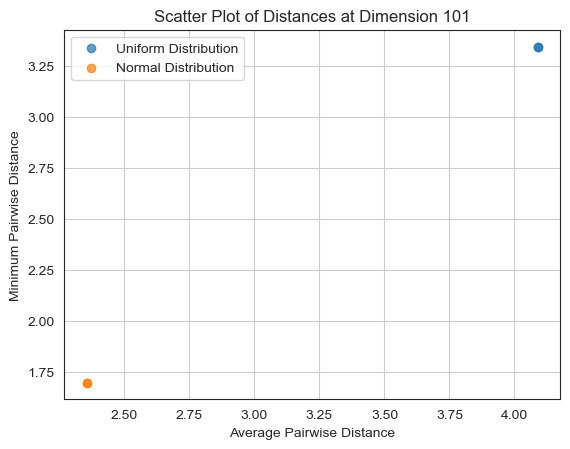

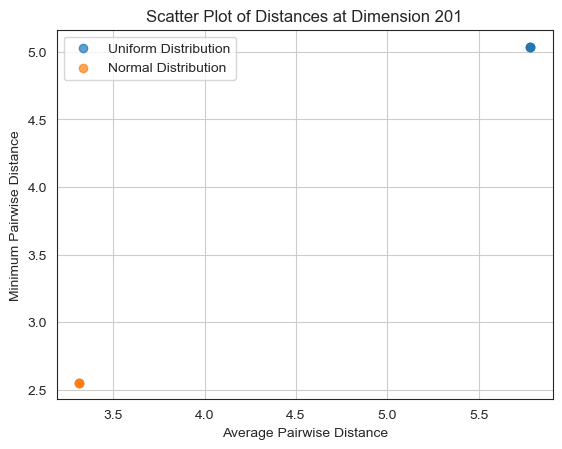

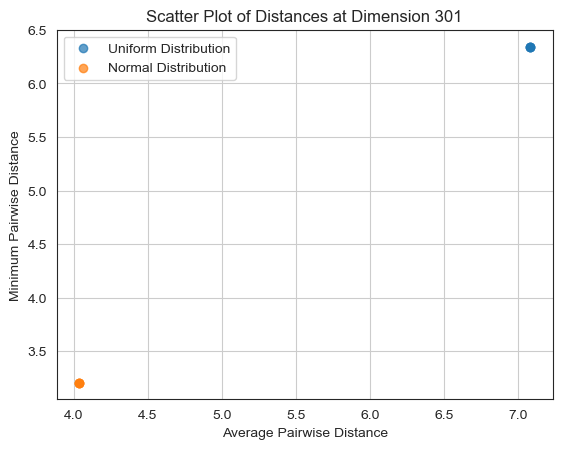

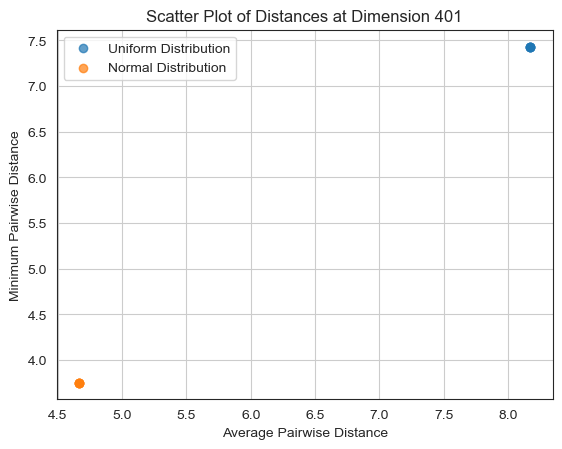

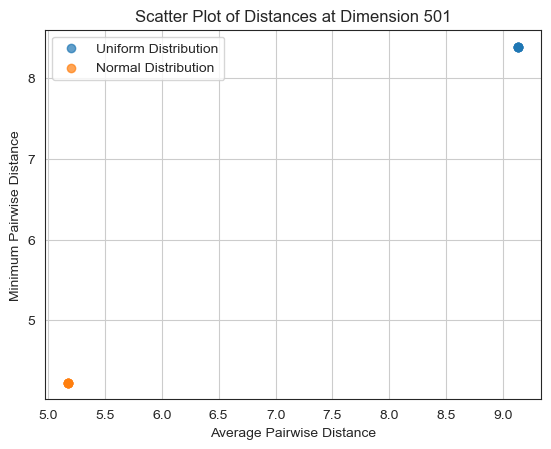

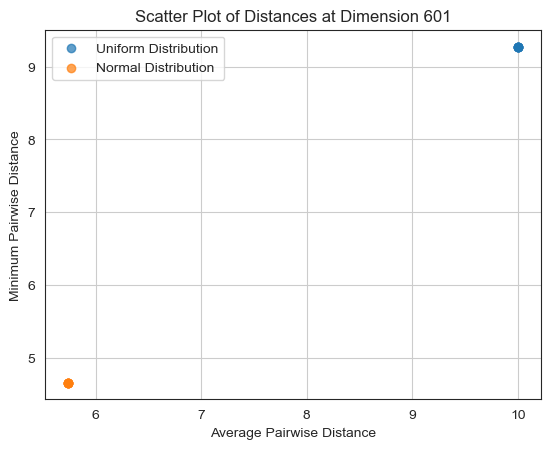

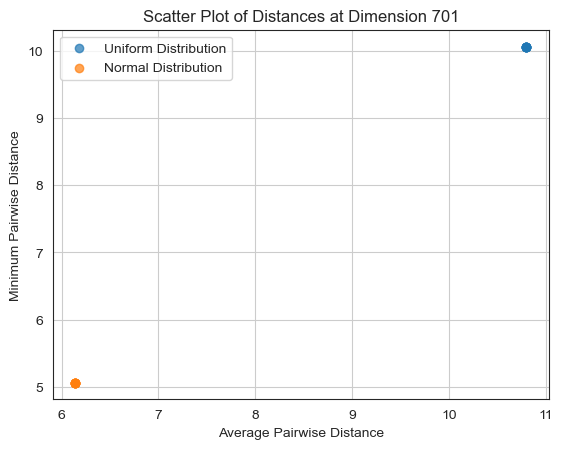

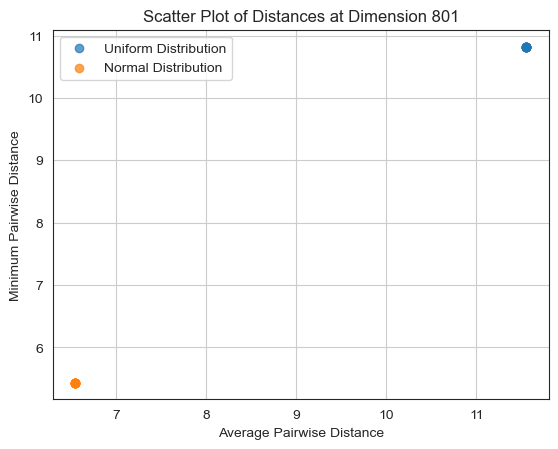

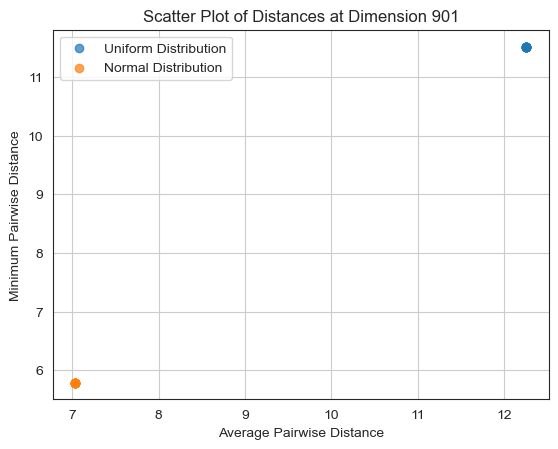

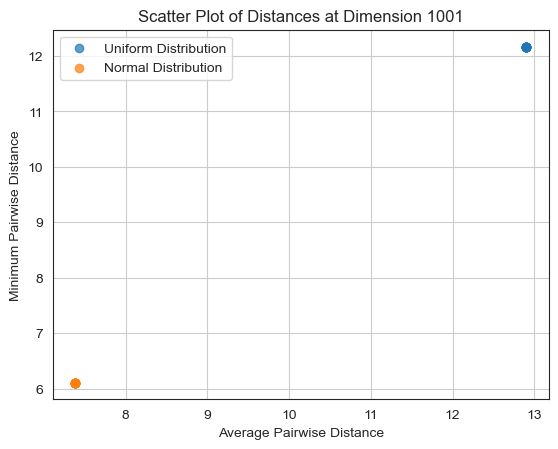

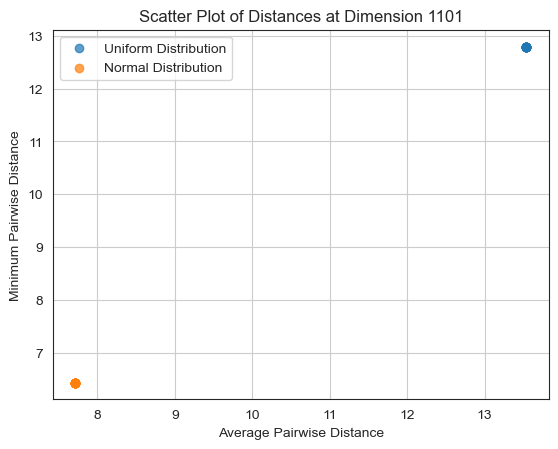

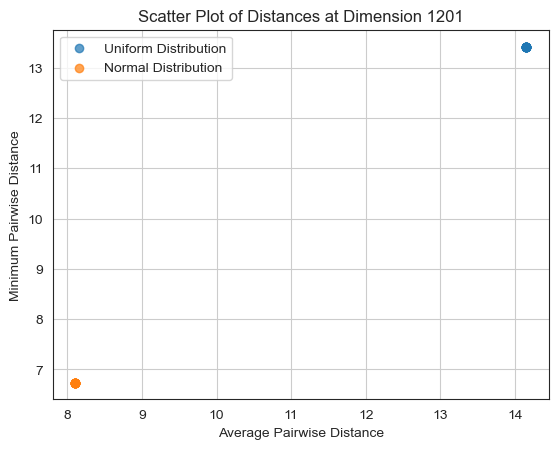

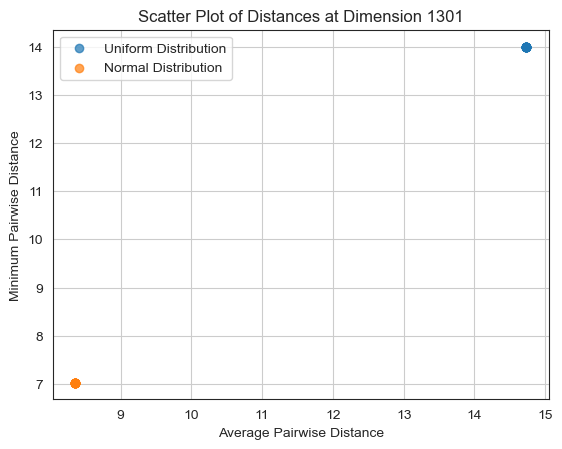

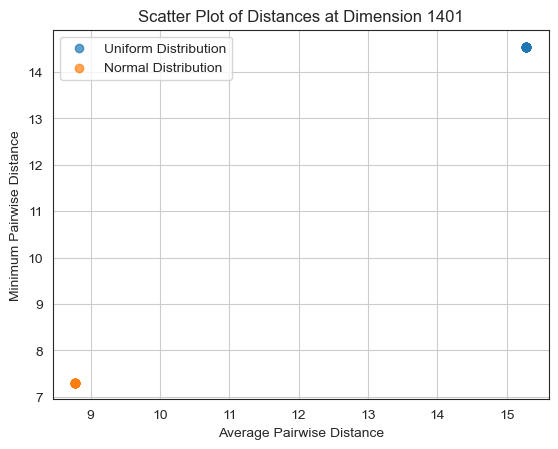

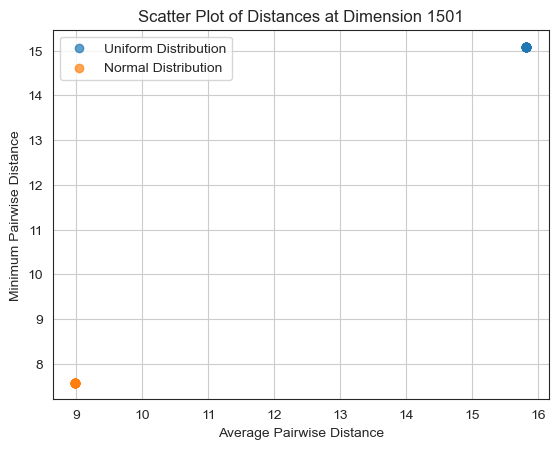

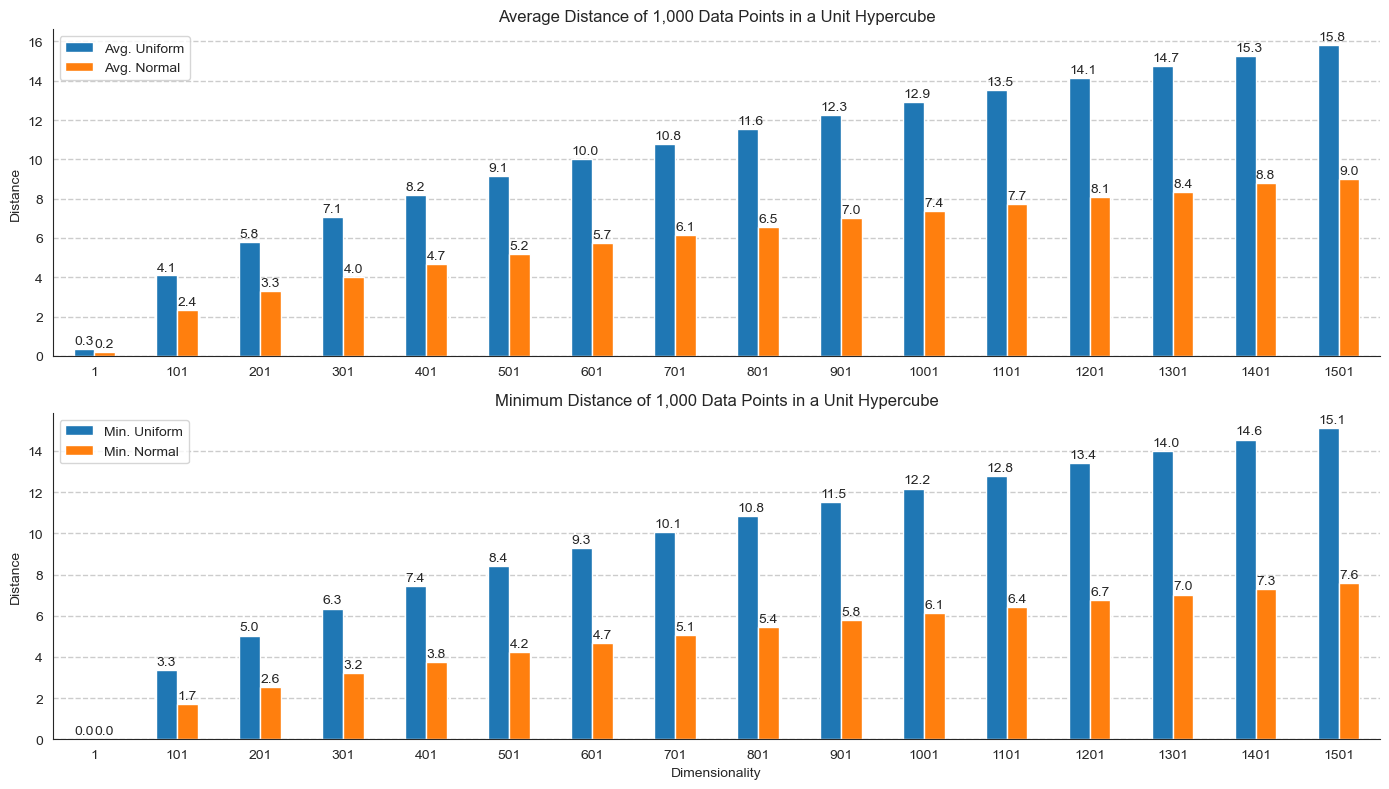

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import clip, full, fill_diagonal
from numpy.random import uniform, multivariate_normal, seed
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

seed(42)
sns.set_style('white')


def get_distance_metrics(points):
    """
    Calculate the mean of pairwise distances and the mean of the minimum pairwise distances
    for a given set of points.

    Parameters:
    points (array): An array of points for which distances are to be calculated.

    Returns:
    tuple: A tuple containing the average pairwise distance and the average minimum distance.
    """

    # Calculate pairwise distances between points
    pairwise_dist = pdist(points)
    pairwise_dist = squareform(pairwise_dist)

    # Replace diagonal with the mean of each row (ignoring diagonal values)
    # np.nanmean is used to ignore NaN values when calculating the mean
    np.fill_diagonal(pairwise_dist, np.nanmean(pairwise_dist, axis=1))

    # Calculate the mean of means of pairwise distances
    avg_distance = np.mean(np.nanmean(pairwise_dist, axis=1))

    # Replace diagonal with the maximum value of each row to avoid zero in min calculation
    np.fill_diagonal(pairwise_dist, np.nanmax(pairwise_dist, axis=1))

    # Calculate the mean of the minimum distances for each point
    avg_min_distance = np.mean(np.nanmin(pairwise_dist, axis=1))

    return avg_distance, avg_min_distance

def simulate_distances(m, n, mean, var, corr):
    """
    Draw m random vectors of dimension n from uniform and normal distributions,
    and calculate their pairwise distance metrics.

    Parameters:
    m (int): Number of points/vectors to generate.
    n (int): Dimension of each vector.
    mean (float): Mean for the normal distribution.
    var (float): Variance for the normal distribution.
    corr (float): Correlation coefficient for the normal distribution.

    Returns:
    tuple: A tuple containing distance metrics for uniform and normal distributions.
    """

    # Generate m points from a uniform distribution and calculate their distance metrics
    points = uniform(size=(m, n))
    uni_dist = get_distance_metrics(points)

    # Create a covariance matrix for the multivariate normal distribution
    cov = np.full(shape=(n, n), fill_value=var * corr)
    np.fill_diagonal(cov, var) # Set the diagonal to variance

    # Generate m points from a multivariate normal distribution
    array = np.full(shape=(n,), fill_value=mean)
    normal_points = multivariate_normal(array, cov, m)

    # Clip the values to be within [0, 1] range
    normal_points = np.clip(normal_points, a_min=0, a_max=1)

    # Calculate distance metrics for the normally distributed points
    norm_dist = get_distance_metrics(normal_points)

    return uni_dist, norm_dist

# Main code
# Sampling Parameters

n_points = 1000
min_dim, max_dim, step = 1, 1502, 100 # from 1 - 2501
dimensions = range(min_dim, max_dim, step)

# Normal Distribution Params

mean = 0.5 
var = (mean/3)**2 # 99% of sample in [0, 1]
corr = 0.25

# Run Simulation

col_names = ['Avg. Uniform', 'Min. Uniform', 'Avg. Normal', 'Min. Normal']

# Initialize avg_dist outside the loop
avg_dist = []

# Set up the initial plot
plt.figure(figsize=(12, 6))
plt.ion()  # Turn on interactive mode for dynamic updating

for dim in dimensions:
    uni_dist, norm_dist = simulate_distances(n_points, dim, mean, var, corr)
    avg_dist_current = []
    avg_dist_current.append([*uni_dist, *norm_dist])
    avg_dist.append([*uni_dist, *norm_dist])

    # Convert current data to DataFrame for plotting
    current_data = pd.DataFrame(data=avg_dist_current, columns=col_names, index=dimensions[:len(avg_dist)])
    
    # Clearing the previous plot
    plt.clf()

    # Plotting each set of distances
    plt.scatter(current_data['Avg. Uniform'], current_data['Min. Uniform'], label='Uniform Distribution', alpha=0.7)
    plt.scatter(current_data['Avg. Normal'], current_data['Min. Normal'], label='Normal Distribution', alpha=0.7)

    # Set plot titles and labels
    plt.title(f'Scatter Plot of Distances at Dimension {dim}')
    plt.xlabel('Average Pairwise Distance')
    plt.ylabel('Minimum Pairwise Distance')
    plt.legend()
    plt.grid(True)

    # Pause briefly to update the plot
    plt.pause(0.1)

plt.ioff()  # Turn off interactive mode
plt.show()  # Show the final plot

# Plot Average and Minimum Distance of Points in Unit Hypercube

distances = pd.DataFrame(data=avg_dist,columns=col_names,index=dimensions)

title = 'Distance of {:,.0f} Data Points in a Unit Hypercube'.format(n_points)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
distances[[ 'Avg. Uniform', 'Avg. Normal']].plot.bar(title='Average ' + title, ax=axes[0], rot=0)
distances[[ 'Min. Uniform', 'Min. Normal']].plot.bar(title='Minimum ' + title, ax=axes[1], rot=0)

for ax in axes:
    ax.grid(axis='y', lw=1, ls='--')
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + .005, p.get_height() + .25), fontsize=10)
    ax.set_ylabel('Distance')

axes[1].set_xlabel('Dimensionality')
sns.despine()        
fig.tight_layout();
